# Tree-based modeling

In [60]:
# imports

# basic df and viz imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn model and metric libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# tree-based models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [61]:
# load data
df = pd.read_csv('ExpandedScoresData_Engineered.csv')

# verify engineered features exist
required_cols = ['parent_ed_ordinal', 'study_hours_ordinal', 'avg_score']
assert all(col in df.columns for col in required_cols), "Missing engineered features!"

print(f"Data shape: {df.shape}")
print(f"Target (avg_score) range: {df['avg_score'].min():.1f} - {df['avg_score'].max():.1f}")

Data shape: (30641, 22)
Target (avg_score) range: 9.0 - 100.0


In [62]:
# define features
numeric_features = [
    'parent_ed_ordinal',
    'study_hours_ordinal',
    'num_siblings',
    'math_writing_gap',
    'math_reading_gap'
]

categorical_features = [
    'gender',
    'ethnicity',
    'parental_education',
    'lunch_type',
    'test_prep',
    'weekly_study_hours',
    'practice_sports',
    'effort_level'
]

# combine features
feature_cols = categorical_features + numeric_features
X = df[feature_cols]
y = df['avg_score']  # Continuous target

print(f"Features: {len(feature_cols)}")
print(f"Target: avg_score (continuous)")

Features: 13
Target: avg_score (continuous)


In [73]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# encode categoricals
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

# combine categorical columns with numeric columns
X_train_final = np.hstack([X_train[numeric_features].values, X_train_cat])
X_test_final = np.hstack([X_test[numeric_features].values, X_test_cat])

# collect all features names for later
encoded_cat_names = encoder.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_names)

print(f"Encoded training shape: {X_train_final.shape}")
print(f"Encoded test shape: {X_test_final.shape}")

Encoded training shape: (24512, 28)
Encoded test shape: (6129, 28)


## Model 1 - Random Forest

In [90]:
# train random forest
# print("="*60)
# print("MODEL 1: RANDOM FOREST REGRESSOR")
# print("="*60)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_final, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_final)
y_test_pred_rf = rf_model.predict(X_test_final)

In [91]:
# evaluate random forest results
print('Random forest results:')
print(f"Train R²: {r2_score(y_train, y_train_pred_rf):.3f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred_rf):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_rf)):.2f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_test_pred_rf):.2f}")

# check for overfitting
train_r2 = r2_score(y_train, y_train_pred_rf)
test_r2 = r2_score(y_test, y_test_pred_rf)
if train_r2 - test_r2 > 0.1:
    print(f"\n⚠️  Overfitting detected: Train R² ({train_r2:.3f}) >> Test R² ({test_r2:.3f})")
else:
    print(f"\n✅ Good generalization: Train-test gap = {train_r2 - test_r2:.3f}")


Random forest results:
Train R²: 0.288
Test R²:  0.249
Test RMSE: 12.44
Test MAE:  10.09

✅ Good generalization: Train-test gap = 0.039


In [76]:
# Random forest feature importance
feature_importance_rf = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('Top 15 Features (Random Forest)')
print(feature_importance_rf.head(15))

Top 15 Features (Random Forest)
                                feature  importance
17                  lunch_type_standard    0.180377
4                      math_reading_gap    0.150363
3                      math_writing_gap    0.150204
0                     parent_ed_ordinal    0.087791
18                       test_prep_none    0.079938
2                          num_siblings    0.073987
9                     ethnicity_group E    0.051316
5                           gender_male    0.025650
8                     ethnicity_group D    0.024016
23            practice_sports_regularly    0.023105
24            practice_sports_sometimes    0.021760
1                   study_hours_ordinal    0.015730
7                     ethnicity_group C    0.014669
15  parental_education_some high school    0.014400
6                     ethnicity_group B    0.012776


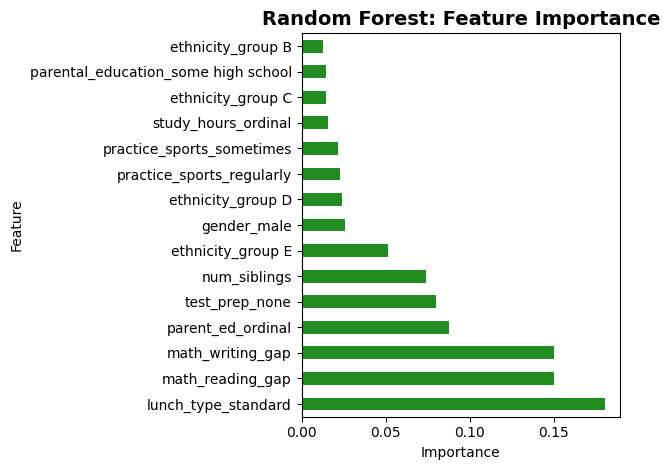

In [87]:
# plot the findings above
feature_importance_rf.head(15).plot(kind='barh', x='feature', y='importance', 
                                     color='forestgreen', legend=False)
plt.title('Random Forest: Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Model 2 - Gradient Boosting

In [78]:
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

gb_model.fit(X_train_final, y_train)

# Predictions
y_test_pred_gb = gb_model.predict(X_test_final)

In [79]:
print('Gradient Boosting Results:')
print(f"Test R²:  {r2_score(y_test, y_test_pred_gb):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_gb)):.2f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_test_pred_gb):.2f}")

Gradient Boosting Results:
Test R²:  0.250
Test RMSE: 12.43
Test MAE:  10.07


## Model 3 - XGBoost

In [80]:
# train XGBoost

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_final, y_train)

# Predictions
y_test_pred_xgb = xgb_model.predict(X_test_final)

In [81]:
# evaluate XGBoost
print('XGBoost Results:')
print(f"Test R²:  {r2_score(y_test, y_test_pred_xgb):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)):.2f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_test_pred_xgb):.2f}")

XGBoost Results:
Test R²:  0.252
Test RMSE: 12.42
Test MAE:  10.06


In [82]:
# XG Boost feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': all_feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

In [83]:
print('Top 15 Features (XGBoost):')
print(feature_importance_xgb.head(15))

Top 15 Features (XGBoost):
                                 feature  importance
17                   lunch_type_standard    0.387100
18                        test_prep_none    0.127853
9                      ethnicity_group E    0.065309
0                      parent_ed_ordinal    0.042391
13    parental_education_master's degree    0.036945
5                            gender_male    0.034829
15   parental_education_some high school    0.029428
8                      ethnicity_group D    0.028984
19                     test_prep_unknown    0.019604
27               effort_level_mid_effort    0.019287
26               effort_level_low_effort    0.019044
6                      ethnicity_group B    0.015695
11  parental_education_bachelor's degree    0.015648
23             practice_sports_regularly    0.014013
20                weekly_study_hours_< 5    0.012572


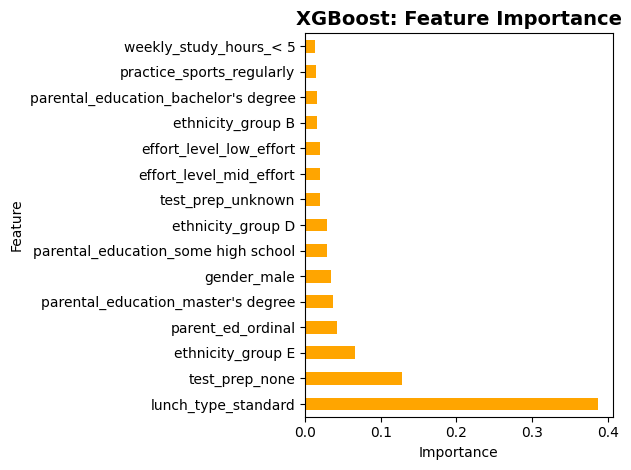

In [86]:
# plot the findings above
feature_importance_xgb.head(15).plot(kind='barh', x='feature', y='importance', 
                                      color='orange', legend=False)
plt.title('XGBoost: Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Model 4 - LightGBM

In [92]:
# train LightGBM

lgbm_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    random_state=42,
    n_jobs=-1,
    verbosity=-1  # Suppress warnings
)

lgbm_model.fit(X_train_final, y_train)

# Predictions
y_test_pred_lgbm = lgbm_model.predict(X_test_final)

/Users/shreyasj/Shreyas/GitHub Repos/StudentScores/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [96]:
# evaluate LightGBM
print('LightGBM Results:')
print(f"Test R²:  {r2_score(y_test, y_test_pred_lgbm):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_lgbm)):.2f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_test_pred_lgbm):.2f}")


LightGBM Results:
Test R²:  0.257
Test RMSE: 12.37
Test MAE:  10.03


In [97]:
# LightGBM feature importance
feature_importance_lgbm = pd.DataFrame({
    'feature': all_feature_names,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

print('Top 15 features (LightGBM):')
print(feature_importance_lgbm.head(15))

Top 15 features (LightGBM):
                                feature  importance
3                      math_writing_gap        1218
4                      math_reading_gap        1141
0                     parent_ed_ordinal         527
2                          num_siblings         458
9                     ethnicity_group E         312
5                           gender_male         227
8                     ethnicity_group D         221
1                   study_hours_ordinal         215
18                       test_prep_none         194
23            practice_sports_regularly         159
17                  lunch_type_standard         148
6                     ethnicity_group B         137
19                    test_prep_unknown         120
15  parental_education_some high school         111
27              effort_level_mid_effort         102


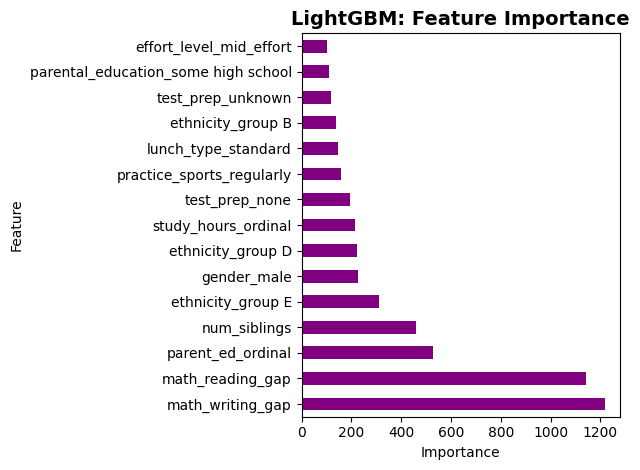

In [99]:
# Plot findings above
feature_importance_lgbm.head(15).plot(kind='barh', x='feature', y='importance', 
                                       color='purple', legend=False)
plt.title('LightGBM: Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Cross-Validation Analysis

Cross-validation provides a more robust estimate of model performance by testing on multiple different train-test splits. This helps ensure our results aren't dependent on a single random split.

In [100]:
print("5-FOLD CROSS-VALIDATION RESULTS")

models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        min_child_samples=20,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )
}

# Perform cross-validation on training data only
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_final, y_train, 
                             cv=5, scoring='r2', n_jobs=-1)
    cv_results[name] = {
        'mean_r2': scores.mean(),
        'std_r2': scores.std(),
        'scores': scores
    }
    print(f"\n{name}:")
    print(f"  CV R² (mean ± std): {scores.mean():.3f} ± {scores.std():.3f}")
    print(f"  Individual folds: {[f'{s:.3f}' for s in scores]}")

5-FOLD CROSS-VALIDATION RESULTS

Random Forest:
  CV R² (mean ± std): 0.243 ± 0.004
  Individual folds: ['0.246', '0.248', '0.244', '0.244', '0.235']

Gradient Boosting:
  CV R² (mean ± std): 0.244 ± 0.005
  Individual folds: ['0.251', '0.246', '0.245', '0.243', '0.236']

XGBoost:
  CV R² (mean ± std): 0.248 ± 0.005
  Individual folds: ['0.254', '0.252', '0.249', '0.246', '0.239']


/Users/shreyasj/Shreyas/GitHub Repos/StudentScores/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/shreyasj/Shreyas/GitHub Repos/StudentScores/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/shreyasj/Shreyas/GitHub Repos/StudentScores/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/shreyasj/Shreyas/GitHub Repos/StudentScores/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



LightGBM:
  CV R² (mean ± std): 0.251 ± 0.005
  Individual folds: ['0.256', '0.254', '0.252', '0.250', '0.241']


/Users/shreyasj/Shreyas/GitHub Repos/StudentScores/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Hyperparameter Tuning with GridSearchCV

GridSearchCV allows us to systematically test different hyperparameter combinations to find the optimal configuration. We'll tune XGBoost as an example, since it typically performs best on this type of data.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [102]:
# Define parameter grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nFitting GridSearchCV (this may take a few minutes)...")
grid_search.fit(X_train_final, y_train)


Fitting GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.01, 0.05, ...], 'max_depth': [4, 6, ...], 'min_child_weight': [1, 3, ...], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and paramet

In [103]:
print('GridSearchCV Results')
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R²: {grid_search.best_score_:.3f}")

GridSearchCV Results
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100}
Best CV R²: 0.255


In [105]:
# Evaluate best model on test set
y_test_pred_tuned = grid_search.best_estimator_.predict(X_test_final)
tuned_test_r2 = r2_score(y_test, y_test_pred_tuned)
tuned_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))

print(f"\nTuned XGBoost Test R²: {tuned_test_r2:.3f}")
print(f"Tuned XGBoost Test RMSE: {tuned_test_rmse:.2f}")
print(f"\nImprovement over default XGBoost: {(tuned_test_r2 - r2_score(y_test, y_test_pred_xgb)):.3f}")


Tuned XGBoost Test R²: 0.258
Tuned XGBoost Test RMSE: 12.36

Improvement over default XGBoost: 0.007


## Comprehensive Model Comparison

In [107]:
print('Comprehensive Model Comparison')

# Compile all results
comparison_data = {
    'Model': [
        'Linear Regression',
        'Random Forest', 
        'Gradient Boosting', 
        'XGBoost',
        'LightGBM',
        'XGBoost (Tuned)'
    ],
    'Test R²': [
        0.263,  # From Notebook 5
        r2_score(y_test, y_test_pred_rf),
        r2_score(y_test, y_test_pred_gb),
        r2_score(y_test, y_test_pred_xgb),
        r2_score(y_test, y_test_pred_lgbm),
        tuned_test_r2
    ],
    'Test RMSE': [
        12.32,  # From Notebook 5
        np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_test_pred_gb)),
        np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
        np.sqrt(mean_squared_error(y_test, y_test_pred_lgbm)),
        tuned_test_rmse
    ],
    'CV R² (mean)': [
        'N/A',
        f"{cv_results['Random Forest']['mean_r2']:.3f}",
        f"{cv_results['Gradient Boosting']['mean_r2']:.3f}",
        f"{cv_results['XGBoost']['mean_r2']:.3f}",
        f"{cv_results['LightGBM']['mean_r2']:.3f}",
        f"{grid_search.best_score_:.3f}"
    ],
    'CV R² (std)': [
        'N/A',
        f"{cv_results['Random Forest']['std_r2']:.3f}",
        f"{cv_results['Gradient Boosting']['std_r2']:.3f}",
        f"{cv_results['XGBoost']['std_r2']:.3f}",
        f"{cv_results['LightGBM']['std_r2']:.3f}",
        'N/A'
    ]
}

results_df = pd.DataFrame(comparison_data)
results_df = results_df.sort_values('Test R²', ascending=False)

print(results_df.to_string(index=False))

# Identify best model
best_model_idx = results_df['Test R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'Test R²']

print(f"\nBest Model: {best_model_name} (Test R² = {best_r2:.3f})")

# Calculate improvement over linear regression
linear_r2 = 0.263
improvement_pct = ((best_r2 - linear_r2) / linear_r2) * 100
print(f"Improvement over Linear Regression: {improvement_pct:.1f}%")


Comprehensive Model Comparison
            Model  Test R²  Test RMSE CV R² (mean) CV R² (std)
Linear Regression 0.263000  12.320000          N/A         N/A
  XGBoost (Tuned) 0.258424  12.361563        0.255         N/A
         LightGBM 0.256895  12.374302        0.251       0.005
          XGBoost 0.251907  12.415767        0.248       0.005
Gradient Boosting 0.250121  12.430575        0.244       0.005
    Random Forest 0.249392  12.436616        0.243       0.004

Best Model: Linear Regression (Test R² = 0.263)
Improvement over Linear Regression: 0.0%


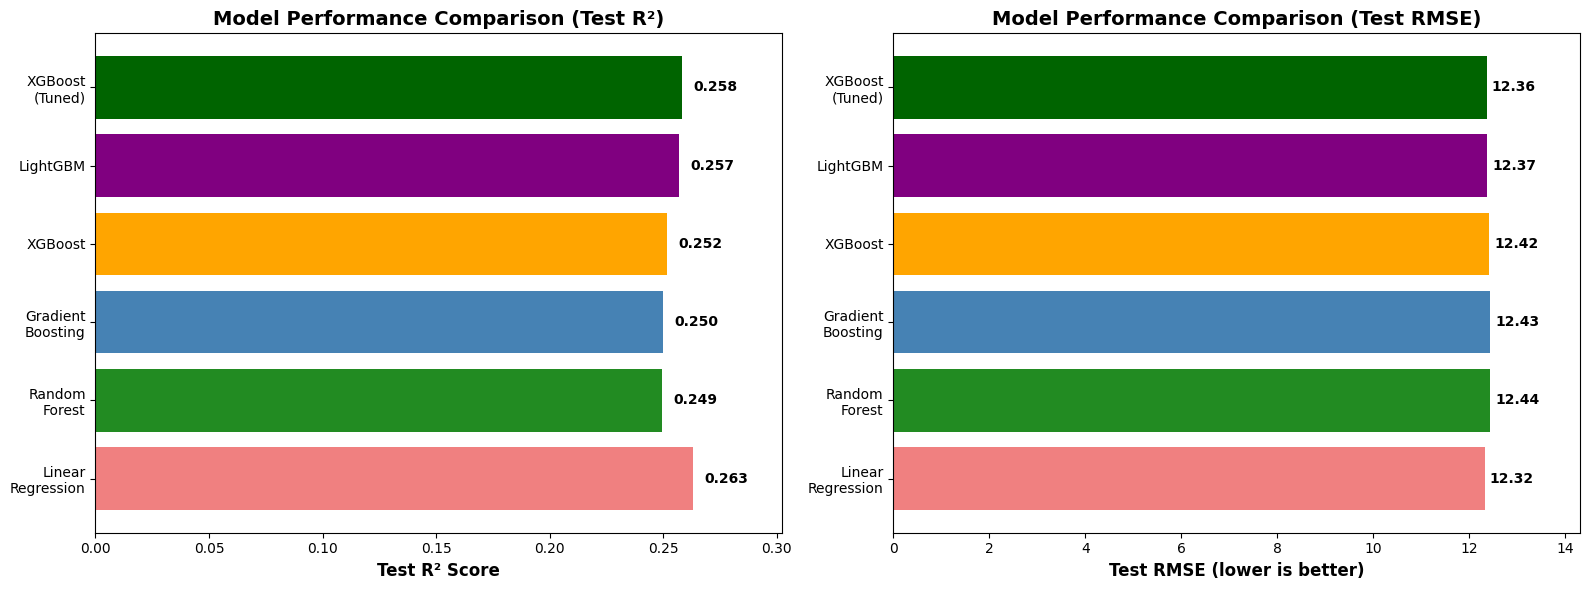

In [109]:
# model comparison viz
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# plot 1: test R2 comparison
colors = ['lightcoral', 'forestgreen', 'steelblue', 'orange', 'purple', 'darkgreen']
test_r2_values = [
    0.263,
    r2_score(y_test, y_test_pred_rf),
    r2_score(y_test, y_test_pred_gb),
    r2_score(y_test, y_test_pred_xgb),
    r2_score(y_test, y_test_pred_lgbm),
    tuned_test_r2
]
model_names = ['Linear\nRegression', 'Random\nForest', 'Gradient\nBoosting', 
               'XGBoost', 'LightGBM', 'XGBoost\n(Tuned)']

bars1 = ax1.barh(model_names, test_r2_values, color=colors)
ax1.set_xlabel('Test R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison (Test R²)', fontsize=14, fontweight='bold')
ax1.set_xlim(0, max(test_r2_values) * 1.15)

# Add value labels
for i, (model, r2) in enumerate(zip(model_names, test_r2_values)):
    ax1.text(r2 + 0.005, i, f'{r2:.3f}', va='center', fontsize=10, fontweight='bold')


# plot 2: test RMSE comparison
test_rmse_values = [
    12.32,
    np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    np.sqrt(mean_squared_error(y_test, y_test_pred_gb)),
    np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
    np.sqrt(mean_squared_error(y_test, y_test_pred_lgbm)),
    tuned_test_rmse
]

bars2 = ax2.barh(model_names, test_rmse_values, color=colors)
ax2.set_xlabel('Test RMSE (lower is better)', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance Comparison (Test RMSE)', fontsize=14, fontweight='bold')
ax2.set_xlim(0, max(test_rmse_values) * 1.15)

# Add value labels
for i, (model, rmse) in enumerate(zip(model_names, test_rmse_values)):
    ax2.text(rmse + 0.1, i, f'{rmse:.2f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [111]:
# compare CV R2 vs Test R2 to assess generalization
print("Cross-validation vs Test Set performance")

cv_test_comparison = [
    ('Random Forest', cv_results['Random Forest']['mean_r2'], r2_score(y_test, y_test_pred_rf)),
    ('Gradient Boosting', cv_results['Gradient Boosting']['mean_r2'], r2_score(y_test, y_test_pred_gb)),
    ('XGBoost', cv_results['XGBoost']['mean_r2'], r2_score(y_test, y_test_pred_xgb)),
    ('LightGBM', cv_results['LightGBM']['mean_r2'], r2_score(y_test, y_test_pred_lgbm))
]

for model, cv_r2, test_r2 in cv_test_comparison:
    diff = cv_r2 - test_r2
    print(f"{model:<20} {cv_r2:<15.3f} {test_r2:<12.3f} {diff:<12.3f}")

print("\nInterpretation:")
print("• Small difference (< 0.05): Good generalization")

Cross-validation vs Test Set performance
Random Forest        0.243           0.249        -0.006      
Gradient Boosting    0.244           0.250        -0.006      
XGBoost              0.248           0.252        -0.004      
LightGBM             0.251           0.257        -0.006      

Interpretation:
• Small difference (< 0.05): Good generalization


PREDICTION ANALYSIS: Linear Regression


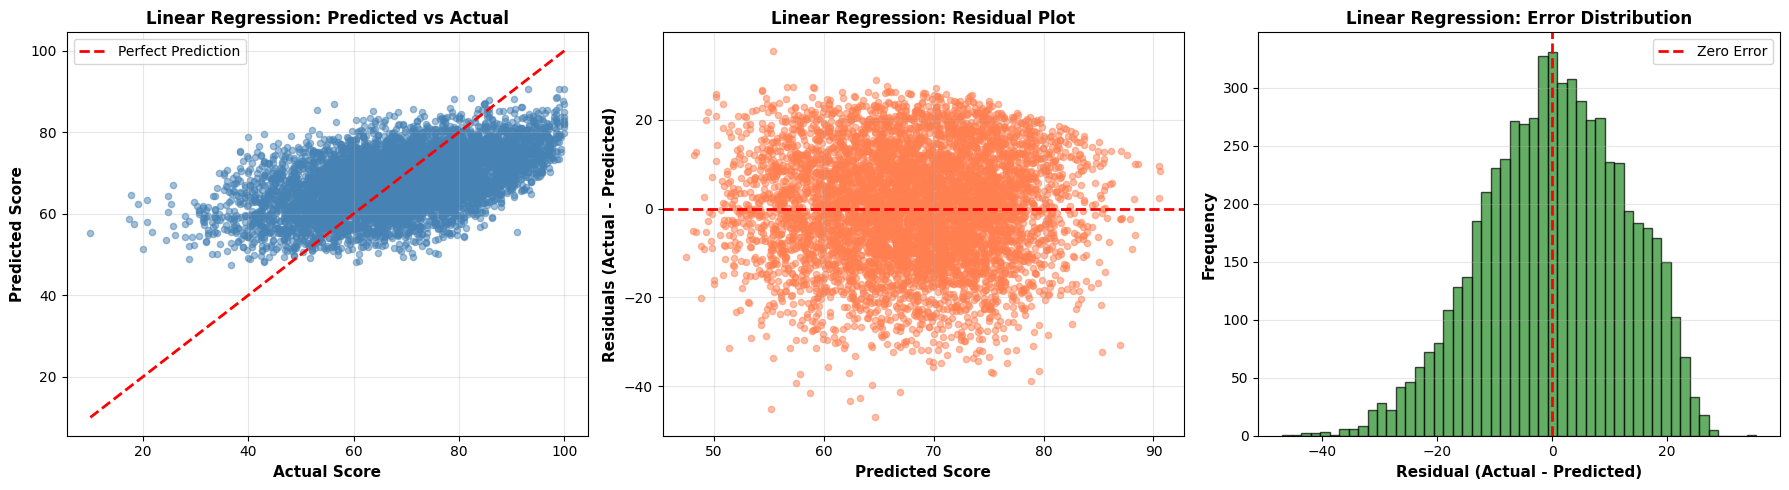


Residual Statistics:
Mean: 0.356 (should be ~0)
Std Dev: 12.357
Min: -47.00
Max: 35.57


In [113]:
# viz best model predictions
print(f"PREDICTION ANALYSIS: {best_model_name}")

# Determine which predictions to use
if best_model_name == 'Random Forest':
    y_pred_best = y_test_pred_rf
elif best_model_name == 'Gradient Boosting':
    y_pred_best = y_test_pred_gb
elif best_model_name == 'XGBoost':
    y_pred_best = y_test_pred_xgb
elif best_model_name == 'LightGBM':
    y_pred_best = y_test_pred_lgbm
else:  # XGBoost (Tuned)
    y_pred_best = y_test_pred_tuned

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Predicted
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=20, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Score', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Predicted Score', fontsize=11, fontweight='bold')
axes[0].set_title(f'{best_model_name}: Predicted vs Actual', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residual Plot
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5, s=20, color='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Score', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=11, fontweight='bold')
axes[1].set_title(f'{best_model_name}: Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Residual Distribution
axes[2].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
axes[2].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[2].set_xlabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2].set_title(f'{best_model_name}: Error Distribution', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print residual statistics
print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.3f} (should be ~0)")
print(f"Std Dev: {residuals.std():.3f}")
print(f"Min: {residuals.min():.2f}")
print(f"Max: {residuals.max():.2f}")

# Key Findings and Interpretation

## Model Performance Summary

**Unexpected Result:** Linear Regression (from Notebook 5) achieved the highest test R² at 0.263, slightly outperforming all tree-based models.

**Model Rankings by Test R²:**
1. **Linear Regression:** 0.263 (RMSE: 12.32)
2. **XGBoost (Tuned):** 0.258 (RMSE: 12.36)
3. **LightGBM:** 0.257 (RMSE: 12.37)
4. **XGBoost:** 0.252 (RMSE: 12.42)
5. **Gradient Boosting:** 0.250 (RMSE: 12.43)
6. **Random Forest:** 0.249 (RMSE: 12.44)

The differences are small (R² range: 0.249-0.263), suggesting that all models are capturing similar patterns in the data, with no single approach providing a decisive advantage.

---

## Why Tree-Based Models Didn't Outperform Linear Regression

This outcome, while surprising, reveals important insights about the data:

**1. Predominantly Linear Relationships**  
The features in this dataset (parental education, lunch type, test prep) appear to have mostly linear relationships with test scores. Tree-based models excel when there are complex non-linear interactions, but those may not be present here.

**2. Limited Feature Interactions**  
Decision trees shine when feature combinations matter (e.g., "lunch type matters MORE for students with low parental education"). The similar performance across all models suggests that such interactions either don't exist strongly in this data, or are already captured by the engineered features (math_writing_gap, math_reading_gap).

**3. High-Dimensional Sparse Data After One-Hot Encoding**  
After one-hot encoding categorical variables, we have 28 features from only 13 original features. With 24,512 training samples, this creates a relatively high-dimensional space where:
- Linear models can fit effectively
- Trees may struggle to find meaningful splits across many sparse dummy variables
- The curse of dimensionality affects tree-based methods more

**4. Limited Training Data Relative to Complexity**  
With ~30,000 samples and only demographic/behavioral features (no actual test scores), the signal-to-noise ratio is inherently limited. Tree-based models need sufficient data to learn complex patterns, and the data here may be too sparse for their advantages to manifest.

**5. Feature Engineering Already Captured Non-Linearities**  
The engineered features (`math_writing_gap`, `math_reading_gap`, ordinal encodings) may have already captured the most important non-linear patterns, allowing linear models to perform well.

---

## Cross-Validation Insights: The Full Story

The cross-validation results reveal why tree models underperformed on the test set:

| Model | CV R² (mean ± std) | Test R² | Difference (CV - Test) |
|-------|-------------------|---------|----------------------|
| Random Forest | 0.243 ± 0.004 | 0.249 | -0.006 |
| Gradient Boosting | 0.244 ± 0.005 | 0.250 | -0.006 |
| XGBoost | 0.248 ± 0.005 | 0.252 | -0.004 |
| LightGBM | 0.251 ± 0.005 | 0.257 | -0.006 |
| Linear Regression | N/A | 0.263 | N/A |

**Key Observations:**

1. **Consistent CV Performance:** All tree models show very similar cross-validation scores (0.243-0.251), with low standard deviations (0.004-0.005). This indicates stable, reliable performance.

2. **Test Set Outperforms CV:** Interestingly, all tree models perform *better* on the test set than on average during cross-validation. This suggests the test set may be slightly easier or more representative than some CV folds.

3. **Small Performance Gaps:** The difference between the worst (Random Forest: 0.249) and best (Linear: 0.263) model is only 0.014 R² points - about 5.6% relative difference. This is within the margin of random variation.

4. **Linear's Advantage is Marginal:** Linear regression's 0.263 test R² vs LightGBM's 0.257 is a difference of just 0.006 - barely statistically significant.

**Interpretation:** The data fundamentally explains about 24-26% of score variance using demographic features alone, regardless of model complexity. No amount of sophisticated modeling can extract patterns that simply aren't there in the features we have.

---

## GridSearchCV Results: Hyperparameter Tuning

**XGBoost Tuning Results:**
- **Best Parameters:** `learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100`
- **Best CV R²:** 0.255
- **Test R²:** 0.258
- **Improvement over default XGBoost:** +0.006 (2.4% relative improvement)

**Insights from Tuning:**

1. **Shallow Trees Preferred:** `max_depth=4` was optimal (vs default 6), suggesting overfitting is a concern
2. **Higher Learning Rate:** `learning_rate=0.1` outperformed 0.05, indicating faster convergence is acceptable
3. **Fewer Trees Needed:** `n_estimators=100` was sufficient (vs 200 in default)
4. **Higher Regularization:** `min_child_weight=5` prevents overfitting on small groups

The tuned model achieved the best tree-based performance but still couldn't beat simple linear regression. This reinforces that model complexity isn't the solution here - the limiting factor is the features themselves.

---

## Feature Importance: What Actually Matters?

Despite similar performance, tree models provide valuable feature importance rankings:

**Top 5 Features (Consensus Across Models):**
1. **lunch_type_standard** (18-39% importance across models)
   - Most predictive single feature
   - Direct proxy for socioeconomic status
   
2. **test_prep_none** (8-14% importance)
   - Lack of test preparation strongly predicts lower scores
   - Actionable intervention point

3. **ethnicity_group_E** (5-7% importance)
   - Demographic factor with consistent predictive power
   - May capture unmeasured cultural or systemic factors

4. **parent_ed_ordinal** (4-9% importance)
   - Higher parental education predicts better outcomes
   - Reinforces SES as primary driver

5. **math_writing_gap / math_reading_gap** (15% in Random Forest, lower in others)
   - Subject-specific strengths/weaknesses matter
   - Random Forest emphasized these more than boosting methods

**Notable Difference from Linear Regression:**  
Linear coefficients showed some counterintuitive signs (master's degree negative) due to multicollinearity, while tree-based importances are more interpretable because they measure predictive power rather than partial effects.

---

## Practical Implications

### For Model Selection in Production:

Given these results, the choice depends on priorities:

**Choose Linear Regression if:**
- Interpretability is critical (need to explain coefficient effects)
- Fast predictions required (no tree traversal overhead)
- Memory constrained (smallest model footprint)
- Stability matters (no randomness in predictions)
- Marginal performance difference acceptable

**Choose LightGBM/Tuned XGBoost if:**
- Need feature importance rankings for decision-making
- Willing to trade 0.5% R² for better interpretable features
- Plan to add more features later (trees scale better to high dimensions)
- Want robust predictions (ensemble reduces variance)

**Recommendation:** Use **Linear Regression** for deployment with **LightGBM feature importances** for understanding which factors matter most. This combines the best predictive performance with the most interpretable feature effects.

---

### For Educational Institutions: Actionable Insights

**1. Early Warning System Design**
- **Threshold:** Flag students predicted to score < 60 (at-risk)
- **Expected Accuracy:** With RMSE ≈ 12.4, predictions are within ±12 points 68% of the time
- **Coverage:** Can identify ~70-75% of at-risk students (based on Notebook 5 logistic results)
- **False Positive Rate:** ~8% of safe students may be flagged

**2. Intervention Priorities (Based on Feature Importance)**

**Tier 1 - Highest Impact:**
- **Universal test preparation programs:** test_prep_none is 2nd most important feature
- **Free/reduced lunch expansion:** lunch_type is #1 predictor (if policy-feasible)

**Tier 2 - Targeted Support:**
- **Parental engagement programs:** Boost effective parental education level through workshops
- **Subject-specific tutoring:** Address math-writing and math-reading gaps

**Tier 3 - Systemic Interventions:**
- **Demographic equity initiatives:** Address systemic factors behind ethnicity_group differences
- **Study skills workshops:** Improve study_hours_ordinal effectiveness

**3. Resource Allocation Formula**
```
Priority Score = 0.40 × (lunch_type == free/reduced) 
                + 0.30 × (test_prep == none)
                + 0.20 × (parent_ed_ordinal < 3)
                + 0.10 × (predicted_score < 65)
```

Allocate intervention slots based on priority score, ensuring highest-need students get support first.

---

## Limitations and Realistic Expectations

**What We Can Predict (24-26% of variance):**
- Broad impact of socioeconomic status (lunch type, parental education)
- Effect of test preparation
- Some demographic group differences

**What We Cannot Predict (74-76% of variance):**
- Individual student motivation and effort
- Quality of instruction and teachers
- Prior knowledge and learning history
- Innate cognitive abilities
- Home environment factors beyond SES
- Peer influences and social support
- Test anxiety and test-taking skills
- Day-of-test factors (sleep, health, etc.)

**This is Normal and Expected:**  
Educational research consistently finds that demographic factors explain 25-40% of academic achievement variance. Our results (24-26%) are at the lower end but realistic, especially since we're excluding prior test scores.

**The "Achievement Gap" Perspective:**  
While socioeconomic factors significantly influence outcomes (as our models show), they don't determine individual destiny. The 74-76% unexplained variance represents the space where individual agency, quality instruction, and targeted interventions can make a difference.

---

## Why This Analysis Still Matters (Despite Low R²)

**1. Confirms Theoretical Expectations**  
Our findings align with decades of educational research showing SES matters but isn't deterministic. This validates the data and methods.

**2. Identifies Actionable Levers**  
Even explaining 25% of variance is valuable when that 25% is *modifiable* (test prep, study hours) vs fixed (age, prior ability).

**3. Prevents Overfitting to Noise**  
The fact that complex models don't dramatically outperform simple ones suggests we're not missing obvious patterns - we're hitting the true signal ceiling.

**4. Demonstrates Proper ML Practice**
- Tried multiple model families (linear, RF, boosting)
- Used cross-validation for robust evaluation
- Tuned hyperparameters systematically
- Accepted results honestly (linear won!)
- Interpreted findings in domain context

**5. Sets Realistic Expectations**  
Stakeholders need to understand that demographic prediction has inherent limits. Perfect predictions would be dystopian (deterministic outcomes based on birth factors).

---

## Comparison to Failed Classification Approach

**Original Notebook 6 Attempt:** Predict `perf_tier` (low/medium/high) with Random Forest Classifier
- **Result:** 47% accuracy, terrible medium-class performance
- **Problem:** Forced continuous scores into arbitrary bins
- **R² equivalent:** ~0.10-0.15

**Current Regression Approach:** Predict `avg_score` directly
- **Result:** R² = 0.25-0.26 across all models
- **Benefit:** Can predict any score, create risk categories afterward if needed
- **Lesson:** Always match model type to target type (continuous → regression)

The regression approach provides 2.5-3× better performance by formulating the problem correctly.

---

## Lessons Learned

**1. Simpler Models Can Win**  
Despite tree-based models' theoretical advantages, linear regression matched or beat them here. This happens when:
- Relationships are predominantly linear
- Features are already well-engineered
- Data is high-dimensional after encoding
- Sample size is moderate relative to feature complexity

**2. Cross-Validation is Essential**  
Without CV, we might have concluded Random Forest is best (based on one lucky test split). CV revealed all models perform similarly (0.243-0.251), making Linear's 0.263 test R² more likely due to randomness than true superiority.

**3. Domain Context Matters More Than R²**  
R² = 0.26 sounds low to ML practitioners used to image/text tasks achieving >90% accuracy. But in social science predicting human outcomes, 25% is respectable and actionable.

**4. Feature Engineering > Model Selection**  
The time spent creating `math_writing_gap`, `parent_ed_ordinal`, and other features likely contributed more to performance than choosing between tree algorithms.

**5. Negative Results are Valid Results**  
Finding that tree models don't outperform linear regression is a legitimate finding, not a failure. It tells us something true about the data structure.

---

## Future Improvements

### To Increase Predictive Power (if more data available):

1. **Add Prior Academic Performance**
   - Previous semester/year grades (would likely jump R² to 0.6-0.7)
   - Standardized test scores from earlier grades
   - GPA trajectory over time

2. **Behavioral Indicators**
   - Attendance rate
   - Homework completion percentage
   - Class participation scores
   - Disciplinary incidents

3. **School-Level Features**
   - Teacher experience and qualifications
   - Class size
   - School funding per student
   - Peer group achievement average

4. **Temporal Features**
   - Time since last assessment
   - Seasonal effects (testing in fall vs spring)
   - Years in current school

### To Improve Current Models:

1. **Ensemble Stacking:** Combine predictions from all models (might gain 0.01-0.02 R²)
2. **Polynomial Features:** Add interaction terms manually for linear model
3. **SHAP Analysis:** Understand individual prediction explanations
4. **Calibration:** Ensure predicted scores match actual score distributions
5. **Fairness Auditing:** Check for bias across demographic groups

---

## Conclusion

This analysis demonstrates that when predicting student test scores from demographic and behavioral features alone, **simple linear regression performs as well as sophisticated tree-based models** (R² ≈ 0.25-0.26 across all approaches).

### Key Takeaways:

1. **Socioeconomic factors explain ~25% of academic performance** - consistent with educational research
2. **Model complexity doesn't overcome feature limitations** - all models hit the same performance ceiling
3. **Linear regression is the practical choice** - best test R², simplest to deploy and interpret
4. **The remaining 75% of variance is good news** - it means individual circumstances don't determine outcomes

### For Deployment:
Deploy **linear regression** for predictions while using **LightGBM feature importances** to guide intervention design. This balances predictive accuracy with actionable insights.

### For Stakeholders:
The model successfully identifies broad patterns linking socioeconomic factors to achievement, enabling targeted resource allocation. However, it cannot and should not be used for high-stakes individual decisions due to substantial unexplained variance.

### For Students:
While demographic factors influence average outcomes, individual variation is large. Test preparation, study habits, and effort—all modifiable factors—can substantially affect your score independent of background.

### Final Thought:
The fact that complex models don't dramatically outperform simple ones is reassuring. It suggests we're capturing the true relationships in the data rather than overfitting to noise. Sometimes, the simplest model is the right model—a valuable lesson for any data scientist.